In [1]:
try:
    from google.colab import drive
    IN_COLAB = True
except ModuleNotFoundError:
    IN_COLAB = False

if IN_COLAB:
    drive.mount('/content/drive')
    %cd /content/drive/MyDrive/Repo/GANs/DCGAN_CSP
    !unzip -q images.zip -d /content/img_align_celeba
    %cd /content

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/17_avP4MLLSuGkh_p0ICR2PwPtNAoNkym/DCGAN_CSP
/content


In [2]:
import argparse
import os
import random

#%matplotlib inline
from pathlib import Path
from typing import Literal, Optional, Tuple, Union

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from IPython.display import HTML
from torch import autograd
from torch.utils.tensorboard import SummaryWriter
from tqdm.notebook import tqdm

In [3]:
import warnings

warnings.filterwarnings("ignore")

In [4]:
# Set random seed for reproducibility
manualSeed = 999
# manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [6]:
# Path to images' directory
image_dir = "img_align_celeba"
root = Path(os.getcwd())
dataroot = root.joinpath(image_dir)

In [7]:
# Dataloader parametres
num_workers = 2
batch_size = 128 * 2

# H = W = image_size for each image
image_size = 128

In [8]:
dataset = dset.ImageFolder(
    root=dataroot,
    transform=transforms.Compose(
        [
            transforms.Resize(image_size),
            transforms.CenterCrop(image_size),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    ),
)

dataloader = torch.utils.data.DataLoader(
    dataset, batch_size, shuffle=True, num_workers=num_workers
)

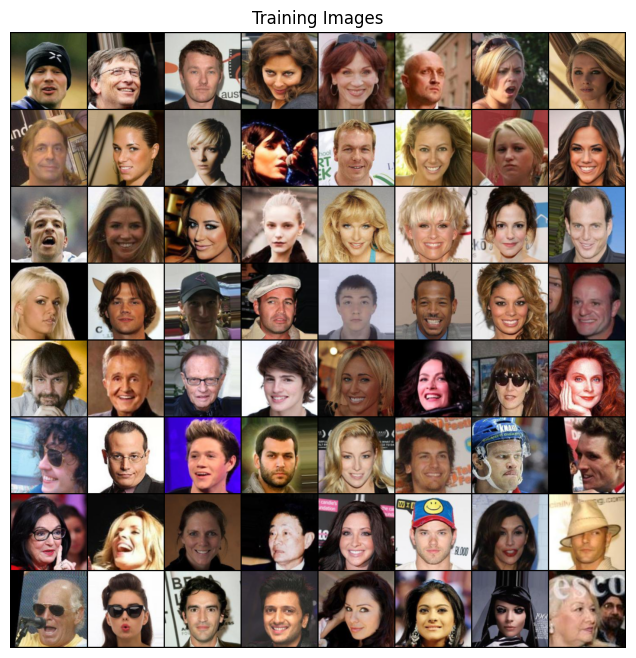

In [9]:
# Show some images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(
    vutils.make_grid(real_batch[0][:64], padding=2, normalize=True)
    .permute(1, 2, 0)
    .to("cpu")
    .numpy()
)

In [10]:
# Number of image channels
nc = 3

# Latent space dimension
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

## Model

In [11]:
class BN_Conv2d(nn.Module):
    """
    BN_CONV, default activation is LeakyReLU
    """

    @property
    def device(self):
        return next(self.parameters()).device

    def __init__(
        self,
        in_channels,
        out_channels,
        kernel_size,
        stride,
        padding,
        dilation=1,
        groups=1,
        bias=False,
        activation=True,
        negative_slope=0.2,
        norm=True,
    ):
        super(BN_Conv2d, self).__init__()
        layers = [
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size=kernel_size,
                stride=stride,
                padding=padding,
                dilation=dilation,
                groups=groups,
                bias=bias,
            )
        ]
        if norm:
            layers.append(nn.BatchNorm2d(out_channels))
        if activation:
            layers.append(nn.LeakyReLU(negative_slope, inplace=True))
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)

In [12]:
class BN_ConvTranspose2d(nn.Module):
    """
    BN_CONV_TRANSPOSE, default activation is LeakyReLU
    """

    @property
    def device(self):
        return next(self.parameters()).device

    def __init__(
        self,
        in_channels,
        out_channels,
        kernel_size,
        stride,
        padding,
        dilation=1,
        groups=1,
        bias=False,
        activation=False,
        negative_slope=0.2,
        norm=True,
    ):
        super(BN_ConvTranspose2d, self).__init__()
        layers = [
            nn.ConvTranspose2d(
                in_channels,
                out_channels,
                kernel_size=kernel_size,
                stride=stride,
                padding=padding,
                dilation=dilation,
                groups=groups,
                bias=bias,
            )
        ]
        if norm:
            layers.append(nn.BatchNorm2d(out_channels))
        if activation:
            layers.append(nn.LeakyReLU(negative_slope, inplace=True))
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)

In [13]:
class Reshape(torch.nn.Module):
    """
    RESHAPE, handy tool for change in tensor representation
    """

    @property
    def device(self):
        return next(self.parameters()).device

    def __init__(self, *args):
        super(Reshape, self).__init__()
        self.dims = args

    def forward(self, x):
        return x.view(x.size(0), *self.dims)

In [14]:
class CSPBlock(nn.Module):
    """
    CSPBLOCK, implementation by definition
    """

    @property
    def device(self):
        return next(self.parameters()).device

    def __init__(self, in_channels, norm=True, part_ratio=0.5):
        super(CSPBlock, self).__init__()
        part1_chnls = int(in_channels * part_ratio)
        part2_chnls = in_channels - part1_chnls
        self.part1_chnls = part1_chnls
        self.part2_chnls = part2_chnls
        self.part1_layer = BN_ConvTranspose2d(
            part1_chnls, part1_chnls, 4, 2, 1, norm=norm
        )

        part2_layers = [
            BN_Conv2d(part2_chnls, part2_chnls, 1, 1, 0, norm=norm),
            BN_ConvTranspose2d(part2_chnls, part2_chnls, 4, 2, 1, norm=norm),
            BN_Conv2d(part2_chnls, part2_chnls, 3, 1, 1, norm=norm),
            BN_Conv2d(part2_chnls, part2_chnls, 3, 1, 1, norm=norm),
        ]

        self.part2_layers = nn.Sequential(*part2_layers)

    def forward(self, x):
        part1 = x[:, : self.part1_chnls, :, :]
        part2 = x[:, self.part1_chnls :, :, :]
        part1 = self.part1_layer(part1)
        part2 = self.part2_layers(part2)
        return part1 + part2

In [15]:
class GAN(torch.nn.Module):
    """
    DCGAN on CSP-blocks implementation
    """

    @property
    def device(self):
        return next(self.parameters()).device

    def __init__(self, nz, norm=True):
        super(type(self), self).__init__()
        self.nz = nz
        self.discriminator = nn.Sequential(
            # Input is N, nc, 128, 128
            BN_Conv2d(nc, ndf, 4, 2, 1, norm=norm),  # to N, ndf, 64, 64
            BN_Conv2d(ndf, ndf * 2, 4, 2, 1, norm=norm),  # to N, ndf * 2, 32, 32
            BN_Conv2d(ndf * 2, ndf * 4, 4, 2, 1, norm=norm),  # to N, ndf * 4, 16, 16
            BN_Conv2d(ndf * 4, ndf * 8, 4, 2, 1, norm=norm),  # to N, ndf * 8, 8, 8
            BN_Conv2d(ndf * 8, ndf * 16, 4, 2, 1, norm=norm),  # to N, ndf * 16, 4, 4
            nn.Conv2d(ndf * 16, 1, 4, 1, 0),  # to N, 1, 1, 1
            Reshape(1),
            nn.Sigmoid(),  # Probability need
        )
        self.generator = torch.nn.Sequential(
            # Input is N, nz
            nn.Linear(nz, ngf * 32),  # to (N, ngf * 32)
            nn.Linear(ngf * 32, ngf * 128),  # to (N, ngf * 128)
            Reshape(ngf * 32, 2, 2),  # to (N, ngf * 32, 2, 2)
            CSPBlock(ngf * 32, norm=norm),  # to (N, ngf * 16, 4, 4)
            CSPBlock(ngf * 16, norm=norm),  # to (N, ngf * 8, 8, 8)
            CSPBlock(ngf * 8, norm=norm),  # to (N, ngf * 4, 16, 16)
            CSPBlock(ngf * 4, norm=norm),  # to (N, ngf * 2, 32, 32)
            CSPBlock(ngf * 2, norm=norm),  # to (N, ngf, 64, 64)
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),  # to (N, nc, 128, 128)
            nn.Tanh(),
        )
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Conv2d) or isinstance(module, nn.ConvTranspose2d):
            nn.init.normal_(module.weight.data, 0.0, 0.02)
        elif isinstance(module, nn.BatchNorm2d):
            nn.init.normal_(module.weight.data, 1.0, 0.02)
            nn.init.constant_(module.bias.data, 0)

    def _generate_noise(self, num_samples):
        """Sample noise from a normal distribution."""
        return torch.randn([num_samples, self.nz], requires_grad=True).to(self.device)

    def generate_samples(self, num_samples):
        """Sample data from noize via the generator."""
        return self.generator(self._generate_noise(num_samples))

## Training code

Определим класс, который будет отвечать за тип гана: как считаем лосс, тип регуляризации

In [16]:
class Trainer(object):
    def __init__(
        self,
        model,
        g_optimizer,
        d_optimizer,
        gan_type: Literal["standard", "wgan"] = "standard",
        reg_type: Literal["R1", "R2", "RLC", "WGAN_GP", "none"] = "none",
        reg_param: Union[float, Tuple[float, float, float]] = 0.1,
    ):

        self.model = model
        self.g_optimizer = g_optimizer
        self.d_optimizer = d_optimizer

        self.gan_type = gan_type
        if gan_type == "wgan":
            if not (reg_type == "WGAN_GP" or reg_type == "none"):
                raise ValueError(
                    "Warning: Please set the regularization type right"
                    "it must be 'WGAN_GP' or 'none' for wgan"
                )
        self.reg_type = reg_type

        if reg_type == "RLC":
            if not (isinstance(reg_param, Tuple) and len(reg_param) == 3):
                raise ValueError(
                    "Warning: Please set the regularization parametres for RLC as"
                    "Tuple(multiplication_factor, alpha_f, alpha_r)"
                )
        self.reg_param = reg_param
        self.criterion = nn.BCELoss()

    def generator_trainstep(self, batch_size):
        """Calculate discriminator loss in generator training stage."""
        toggle_grad(self.model.generator, True)
        toggle_grad(self.model.discriminator, False)
        self.model.train()
        self.g_optimizer.zero_grad()

        fake_output = self.model.discriminator(self.model.generate_samples(batch_size))
        D_G_z2 = fake_output.mean().item()

        errG = self.compute_loss(fake_output, 1)
        errG.backward()

        self.g_optimizer.step()

        return errG.item(), D_G_z2

    def discriminator_trainstep(self, x_batch):
        """Calculate discriminator loss in discriminator training stage."""
        toggle_grad(self.model.generator, False)
        toggle_grad(self.model.discriminator, True)
        self.model.train()
        self.d_optimizer.zero_grad()

        # On real data
        x_batch.requires_grad_()
        real_output = self.model.discriminator(x_batch)
        D_x = real_output.mean().item()

        errD_real = self.compute_loss(real_output, 1)

        if self.reg_type == "R1":
            errD_real.backward(retain_graph=True)
            reg = self.reg_param * compute_grad_norm(errD_real, x_batch)
            reg.backward()
        elif self.reg_type == "RLC":
            errD_real.backward(retain_graph=True)
        else:
            errD_real.backward()

        # On fake data
        batch_size = x_batch.size(0)
        fake_batch = self.model.generate_samples(batch_size).detach()

        fake_batch.requires_grad_()
        fake_output = self.model.discriminator(fake_batch)
        D_G_z1 = fake_output.mean().item()

        errD_fake = self.compute_loss(fake_output, 0)

        if self.reg_type == "R2":
            errD_fake.backward(retain_graph=True)
            reg = self.reg_param * compute_grad_norm(errD_fake, fake_batch)
            reg.backward()
        elif self.reg_type == "RLC":
            errD_fake.backward(retain_graph=True)
        else:
            errD_fake.backward()

        if self.reg_type == "WGAN_GP":
            reg = self.wgan_reg(x_batch, fake_batch)
            reg.backward()
        elif self.reg_type == "RLC":
            reg = self.rlc_reg(real_output, fake_output)
            reg.backward()

        self.d_optimizer.step()

        errD = errD_real.item() + errD_fake.item()

        if self.reg_type == "none":
            reg = torch.tensor(0.0)

        return errD, D_x, D_G_z1, reg.item()

    def compute_loss(self, d_out, target):
        targets = d_out.new_full(size=d_out.size(), fill_value=target)

        if self.gan_type == "standard":
            loss = self.criterion(d_out, targets)
        elif self.gan_type == "wgan":
            loss = (1 - 2 * target) * d_out.mean()
        else:
            raise NotImplementedError

        return loss

    def rlc_reg(self, d_out_fake, d_out_real):
        rlc_mf, rlc_af, rlc_ar = self.reg_param
        reg = (d_out_real - rlc_af).norm(dim=-1).pow(2).mean() + (
            d_out_fake - rlc_ar
        ).norm(dim=-1).pow(2).mean()
        return rlc_mf * reg

    def wgan_reg(self, x_batch, fake_batch):
        batch_size = x_batch.size(0)
        eps = torch.rand((batch_size, 1), device=self.model.device)
        x_interp = eps * x_batch + (1 - eps) * fake_batch
        x_interp = x_interp.detach()
        x_interp.requires_grad_()
        interp_output = self.model.discriminator(x_interp)
        gradients = autograd.grad(
            outputs=interp_output.sum(),
            inputs=x_interp,
            create_graph=True,
            retain_graph=True,
        )[0]

        reg = (
            self.reg_param
            * (gradients.view(batch_size, -1).norm(dim=1) - 1).pow(2).mean()
        )

        return reg

In [17]:
# Utility functions
def compute_grad_norm(d_output, batch):
    batch_size = batch.size(0)

    grad_dout = autograd.grad(
        outputs=d_output.sum(), inputs=batch, create_graph=True, retain_graph=True
    )[0]

    reg = grad_dout.pow(2).view(batch_size, -1).sum(1).mean()
    return reg


def toggle_grad(model, requires_grad):
    for p in model.parameters():
        p.requires_grad_(requires_grad)

In [18]:
def train_on_batch(step, n_critic, x_batch, trainer):
    errD, D_x, D_G_z1, reg = trainer.discriminator_trainstep(x_batch)

    if step % n_critic == 0:
        errG, D_G_z2 = trainer.generator_trainstep(len(x_batch))
    else:
        errG = D_G_z2 = False

    return (errD, errG, D_x, D_G_z1, D_G_z2, reg)

In [19]:
def train_epoch(n_critic, train_generator, trainer, callback=None):
    epoch_loss_D = 0
    epoch_loss_G = 0
    total = 0
    for step, (x_batch, _) in enumerate(train_generator, start=1):
        batch_loss = train_on_batch(step, n_critic, x_batch.to(model.device), trainer)

        if callback:
            callback(trainer, batch_loss)

        epoch_loss_D += batch_loss[0] * len(x_batch)
        epoch_loss_G += batch_loss[1] * len(x_batch)
        total += len(x_batch)

    return epoch_loss_D / total, epoch_loss_G / (total // n_critic)

In [20]:
def trainer(
    count_of_epoch,
    n_critic,
    dataset,
    dataloader,
    model,
    batch_size,
    lr_g,
    lr_d,
    beta1,
    gan_type: Literal["standard", "wgan"] = "standard",
    reg_type: Literal["R1", "R2", "RLC", "WGAN_GP", "none"] = "none",
    reg_param: Union[float, Tuple[float, float, float]] = 0.1,
    callback=None,
    reduce_n_critic=True,
):
    g_optimizer = optim.Adam(
        model.generator.parameters(), lr=lr_g, betas=(beta1, 0.999)
    )
    d_optimizer = optim.Adam(
        model.discriminator.parameters(), lr=lr_d, betas=(beta1, 0.999)
    )

    trainer = Trainer(model, g_optimizer, d_optimizer, gan_type, reg_type, reg_param)

    iterations = tqdm(range(count_of_epoch), desc="epoch")
    iterations.set_postfix({"epoch loss": np.nan})
    for it in iterations:
        batch_generator = tqdm(
            dataloader,
            leave=False,
            total=len(dataset) // batch_size + (len(dataset) % batch_size > 0),
        )

        if reduce_n_critic:
            n_critic -= 2
            if not n_critic:
                n_critic = 1
                reduce_n_critic = False

        epoch_loss_D, epoch_loss_G = train_epoch(
            n_critic,
            batch_generator,
            trainer,
            callback,
        )

        iterations.set_postfix_str(
            f"epoch loss D: {epoch_loss_D}, epoch loss G: {epoch_loss_G}"
        )

In [21]:
class Callback(object):
    "Log all losses, scores and keep track progress in sampling from constant noise"

    def __init__(self, writer, nz, batch_size=64, delimeter=100):
        self.step = 0
        self.writer = writer
        self.delimeter = delimeter
        self.fixed_noise = torch.randn(batch_size, nz)

    def forward(self, trainer, loss):
        errD, errG, D_x, D_G_z1, D_G_z2, reg = loss
        self.step += 1
        self.writer.add_scalar("D/loss", errD, self.step)
        self.writer.add_scalar("scores/D_x", D_x, self.step)
        self.writer.add_scalar("scores/D_G_z1", D_G_z1, self.step)
        if errG and D_G_z2:
            self.writer.add_scalar("G/loss", errG, self.step)
            self.writer.add_scalar("scores/D_G_z2", D_G_z2, self.step)
        self.writer.add_scalar(f"reg/{trainer.reg_type}", reg, self.step)

        if self.step % self.delimeter == 0:
            # Sample from constant noise
            data_batch = trainer.model.generator(
                self.fixed_noise.to(trainer.model.device)
            )
            img_grid = vutils.make_grid(data_batch)
            writer.add_image("Sampled from noise via generator", img_grid, self.step)

    @torch.no_grad()
    def __call__(self, trainer, loss):
        return self.forward(trainer, loss)

## Model initialization

In [22]:
model = GAN(nz)
_ = model.to(device)

Посмотрим на сэмплирование до обучения

In [27]:
def show_images(x_batch):
    plt.figure(figsize=(8, 8))
    plt.axis("off")
    plt.title("Sampled from noise via generator")
    plt.imshow(vutils.make_grid(x_batch).permute(1, 2, 0).numpy())

In [28]:
def generate_samples(model, num_samples, batch_size):
    size = 0
    res = []
    while size < num_samples:
        res.append(model.generate_samples(min(batch_size, num_samples - size)))
        size += batch_size
    return torch.cat(res, 0).to("cpu").detach()

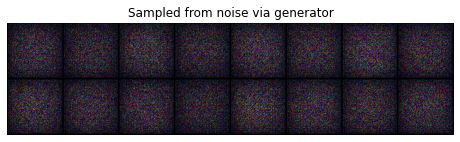

In [ ]:
show_images(generate_samples(model, 16, 8))

## Training

In [23]:
# Training parametres
num_epochs = 4
n_critic = 5
lr_g = 0.0002
lr_d = 0.0002
beta1 = 0.5

Обучаем ГАНЫ, строя всевозможные валидные комбинации лоссов (сейчас стандартный и Вассерштайн) и регуляризаций (их параметры закреплены)

In [ ]:
for gan_type in ["standard", "wgan"]:
    for reg_type in ["none", "R1", "R2", "RLC", "WGAN_GP"]:

        # Skip incompatible combinations
        if gan_type == "wgan" and reg_type in ["R1", "R2", "RLC"]:
            continue
        if gan_type == "standard" and reg_type == "WGAN_GP":
            continue

        model = GAN(nz, gan_type != "wgan")  # Remove BN if Wasserstein GAN
        _ = model.to(device)

        writer = SummaryWriter(log_dir=f"GAN/{gan_type}/{reg_type}")
        callback = Callback(writer, nz, delimeter=500)

        # Will use only "default" regularization params
        if reg_type in ["R1", "R2", "WGAN_GP", "none"]:
            reg_param = 0.2
        elif reg_type == "RLC":
            reg_param = (0.15, 1, 1)

        print("New training started")
        trainer(
            count_of_epoch=num_epochs,
            n_critic=n_critic,
            dataset=dataset,
            dataloader=dataloader,
            model=model,
            batch_size=batch_size,
            lr_g=lr_g,
            lr_d=lr_d,
            beta1=beta1,
            gan_type=gan_type,
            reg_type=reg_type,
            reg_param=reg_param,
            callback=callback,
        )
        print("Training was completed")

New training started


epoch:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Training was completed


In [ ]:
%load_ext tensorboard
%tensorboard --logdir GAN/

Обучение одной конфигурации

In [24]:
gan_type = "standard"
reg_type = "RLC"

model = GAN(nz, True)
_ = model.to(device)

writer = SummaryWriter(
    log_dir="/content/drive/MyDrive/Repo/GANs/DCGAN_CSP/standard_RLC"
)
callback = Callback(writer, nz, delimeter=300)

reg_param = (0.2, 1, 1)

trainer(
    count_of_epoch=num_epochs,
    n_critic=n_critic,
    dataset=dataset,
    dataloader=dataloader,
    model=model,
    batch_size=batch_size,
    lr_g=lr_g,
    lr_d=lr_d,
    beta1=beta1,
    gan_type=gan_type,
    reg_type=reg_type,
    reg_param=reg_param,
    callback=callback,
)

epoch:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/792 [00:00<?, ?it/s]

  0%|          | 0/792 [00:00<?, ?it/s]

  0%|          | 0/792 [00:00<?, ?it/s]

  0%|          | 0/792 [00:00<?, ?it/s]

In [25]:
with open("standard_RLC_2", "wb") as fp:
    torch.save(model.state_dict(), fp)

In [ ]:
# with open("WGAN_GP_model", "rb") as f:
#     state_dict = torch.load(f, map_location=device)
# model = GAN()
# model.load_state_dict(state_dict, strict=False)
# model.to(device)

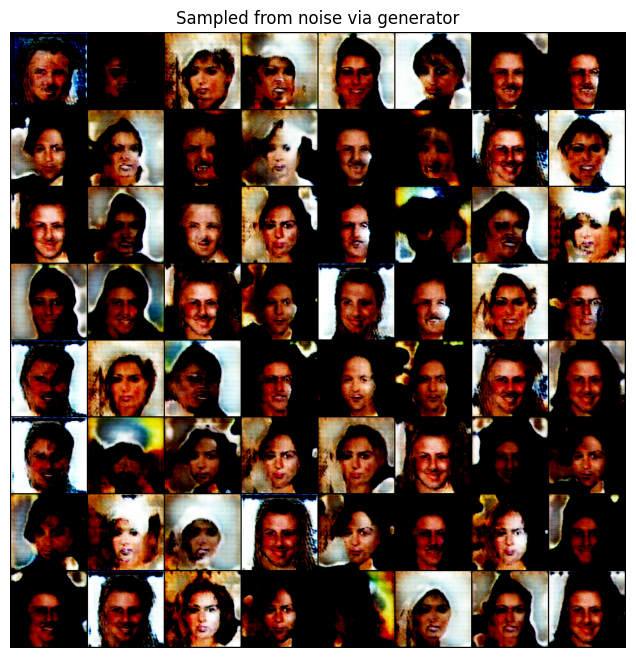

In [29]:
show_images(generate_samples(model, 64, 8))